# Construct the training data into Data format

In [1]:
import sys
sys.path.append("../src")

import torch
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from torch_geometric.data import Data
from reachability_model_function import build_graph_reachability
from dataset_function import generate_labeled_route_no_sides
from torch_geometric.loader import DataLoader
from reachability_model_function import ReachabilityGNN
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from reachability_model_function import FocalLoss

In [2]:
dataset = pd.read_csv("../data/reachability_dataset.csv")

In [3]:
for name in dataset.columns:
    dataset[name] = dataset[name].apply(literal_eval)

In [4]:
# graph_list: each graph is a training sample
graph_list = []

for _, row in dataset.iterrows():
    labels = generate_labeled_route_no_sides(row["route"], row["hands"], row["feet"], row["climber"])
    if labels.count(0) / len(labels) < 0.95:
        data = build_graph_reachability(row["route"], row["hands"], row["feet"], row["climber"], labels)
        graph_list.append(data)

In [6]:
len(graph_list)

89898

In [7]:
# Save the graph_list to local
torch.save(graph_list, "graph_list_global.pt")

# Train the Model

In [2]:
# Load pt file
graph_list = torch.load("graph_list_global.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_28776\1285557832.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global.pt")


In [4]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

In [5]:
all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float)

print("Used Weights:", weights)

Used Weights: tensor([0.3115, 1.8765, 5.0000, 2.1835])


# Use Balanced

In [6]:
all_train_labels = []
for g in train_data:
    all_train_labels.extend(g.y.cpu().numpy())  

classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_train_labels)

weights = np.clip(weights, a_min=None, a_max=5.0)
weights = torch.tensor(weights, dtype=torch.float)

print("Balanced weights:", weights)

Balanced weights: tensor([0.3414, 1.6327, 5.0000, 2.2193])


In [7]:
# shuffle=True: Shuffle the order of the graph at each epoch to enhance the model's generalisation ability.
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# CrossEntropy
# loss_fn = nn.CrossEntropyLoss(weight=weights)

# Focal Loss
loss_fn = FocalLoss(gamma=2.0, weight=weights)


for epoch in range(50):
    total_loss = 0
    model.train()
    for batch in loader:
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 2194.9820
Epoch 1, Loss: 1710.5219
Epoch 2, Loss: 1588.8375
Epoch 3, Loss: 1511.2485
Epoch 4, Loss: 1452.8537
Epoch 5, Loss: 1416.9132
Epoch 6, Loss: 1389.5495
Epoch 7, Loss: 1362.9584
Epoch 8, Loss: 1348.2393
Epoch 9, Loss: 1330.6868
Epoch 10, Loss: 1314.4618
Epoch 11, Loss: 1306.4798
Epoch 12, Loss: 1295.6936
Epoch 13, Loss: 1287.5873
Epoch 14, Loss: 1269.3200
Epoch 15, Loss: 1261.9378
Epoch 16, Loss: 1259.3330
Epoch 17, Loss: 1241.2211
Epoch 18, Loss: 1244.7988
Epoch 19, Loss: 1233.0208
Epoch 20, Loss: 1232.0543
Epoch 21, Loss: 1231.5436
Epoch 22, Loss: 1210.4020
Epoch 23, Loss: 1218.3384
Epoch 24, Loss: 1216.3873
Epoch 25, Loss: 1189.3506
Epoch 26, Loss: 1189.1358
Epoch 27, Loss: 1176.9960
Epoch 28, Loss: 1189.6420
Epoch 29, Loss: 1171.2626
Epoch 30, Loss: 1175.9565
Epoch 31, Loss: 1178.6139
Epoch 32, Loss: 1158.4351
Epoch 33, Loss: 1177.3051
Epoch 34, Loss: 1153.6590
Epoch 35, Loss: 1151.2473
Epoch 36, Loss: 1162.9276
Epoch 37, Loss: 1144.1763
Epoch 38, Loss: 1150.8

In [8]:
from torch_geometric.data import Batch
from collections import Counter

model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g])     
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 3677483, 1: 2366943, 3: 1046744, 2: 29144})


In [ ]:
model.eval()
with torch.no_grad():
    preds = []
    for g in graph_list[:30]:
        p = model(g).argmax(dim=1)
        preds.extend(p.tolist())

print("Distribution of Predictions:", Counter(preds))

In [10]:
torch.save(model.state_dict(),"reachability_model7.pt")

In [11]:
# Load the model
model = ReachabilityGNN()
model.load_state_dict(torch.load("reachability_model7.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_28776\814691582.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_model7.pt"))


ReachabilityGNN(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 64)
  (climber_embed): Linear(in_features=4, out_features=64, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [2]:
graph_list = torch.load("graph_list.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_14260\2863085696.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list.pt")


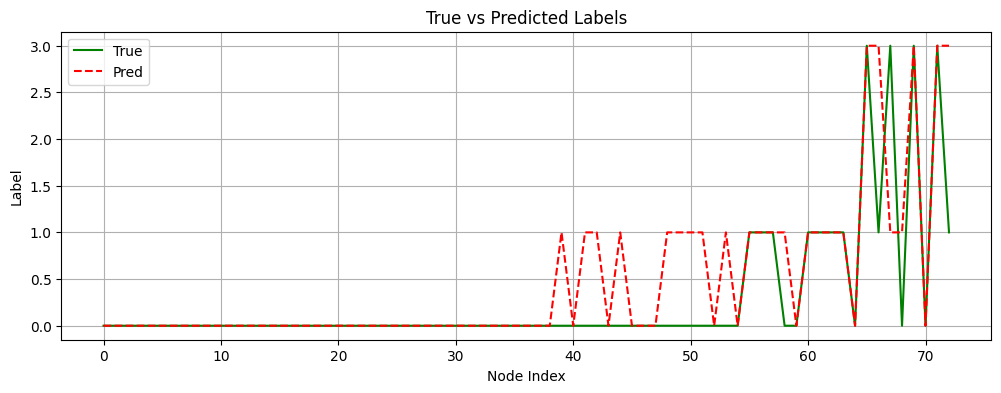

In [12]:
import matplotlib.pyplot as plt
graph = test_data[2450]
batch = Batch.from_data_list([graph])

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [13]:
all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

              precision    recall  f1-score   support

 unreachable       1.00      0.70      0.83   1297835
        hand       0.38      0.82      0.52    269960
        foot       0.11      0.24      0.15      3458
        both       0.71      0.92      0.80    201083

    accuracy                           0.74   1772336
   macro avg       0.55      0.67      0.57   1772336
weighted avg       0.87      0.74      0.77   1772336

